# Advanced Models: Tree-Based Gradient Boosting

## 1. Imports and Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import sys
import os

# Add src to path
sys.path.append(os.path.abspath('..'))

from src.models import XGBoostModel, LightGBMModel, CatBoostModel
from src.utils.metrics import calculate_metrics

# Set plots style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load Processed Data

In [3]:
train_df = pd.read_csv('../data/processed/train_featurized.csv')
test_df = pd.read_csv('../data/processed/test_featurized.csv')

X = train_df.drop(['id', 'SMILES', 'Tm'], axis=1)
y = train_df['Tm']
X_test = test_df.drop(['id', 'SMILES'], axis=1)

# Tree models handle NaNs natively, but we should check if they need specific handling
# XGBOOST, LightGBM, CatBoost handle NaNs automatically.

print(f'Train shape: {X.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (2662, 2856)
Test shape: (666, 2856)


## 3. Model Training and Evaluation
Using 5-Fold Cross-Validation for XGBoost, LightGBM, and CatBoost.

In [4]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

model_classes = {
    'XGBoost': XGBoostModel,
    'LightGBM': LightGBMModel,
    'CatBoost': CatBoostModel
}

results = []
oof_preds = pd.DataFrame(index=X.index, columns=model_classes.keys())
test_preds_dict = {}

for name, ModelClass in model_classes.items():
    print(f"\nTraining {name}...")
    
    fold_metrics = []
    test_fold_preds = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = ModelClass()
        model.fit(X_train, y_train, X_val, y_val)
        
        val_pred = model.predict(X_val)
        oof_preds.loc[val_idx, name] = val_pred
        
        metrics = calculate_metrics(y_val, val_pred)
        fold_metrics.append(metrics)
        
        # Predict on test set
        test_fold_preds.append(model.predict(X_test))
        
    avg_mae = np.mean([m['MAE'] for m in fold_metrics])
    avg_r2 = np.mean([m['R2'] for m in fold_metrics])
    print(f"{name} Average CV MAE: {avg_mae:.4f}, R2: {avg_r2:.4f}")
    
    results.append({
        'Model': name,
        'MAE': avg_mae,
        'R2': avg_r2
    })
    
    # Average predictions across folds
    test_preds_dict[name] = np.mean(test_fold_preds, axis=0)

results_df = pd.DataFrame(results)
display(results_df)


Training XGBoost...
XGBoost Average CV MAE: 27.8266, R2: 0.7435

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19507
[LightGBM] [Info] Number of data points in the train set: 2129, number of used features: 635
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 278.149994
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's l1: 28.8808
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 

,Model,MAE,R2
0,XGBoost,27.826637,0.743468
1,LightGBM,27.928244,0.742736
2,CatBoost,27.834415,0.736101


## 4. Feature Importance
Visualizing feature importance for each model.

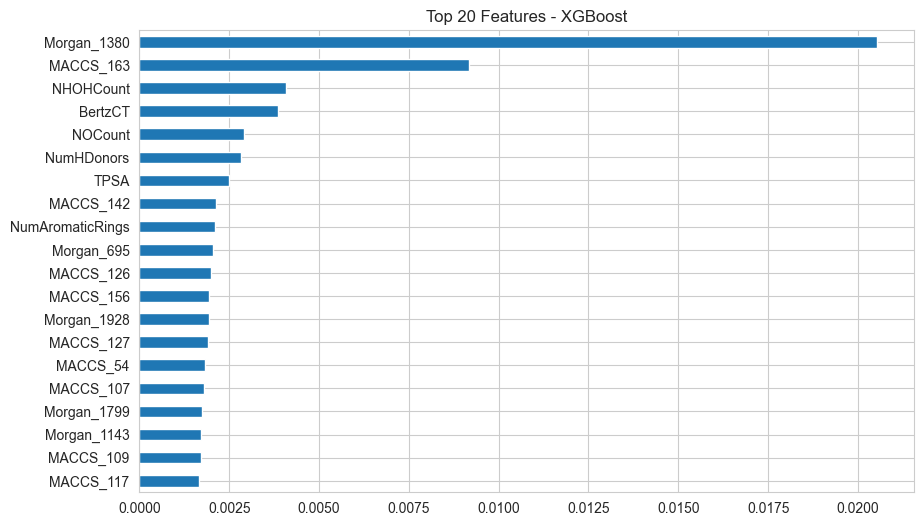

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20255
[LightGBM] [Info] Number of data points in the train set: 2662, number of used features: 707
[LightGBM] [Info] Start training from score 277.299988


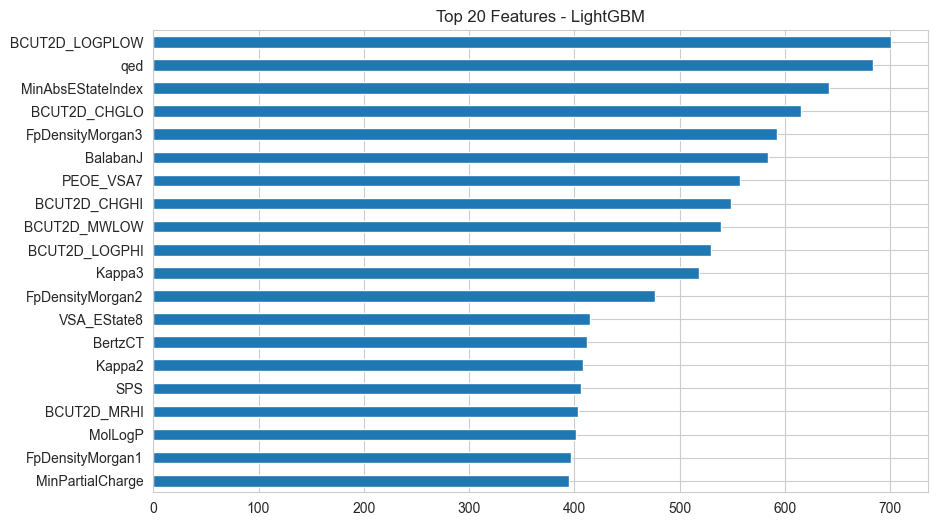

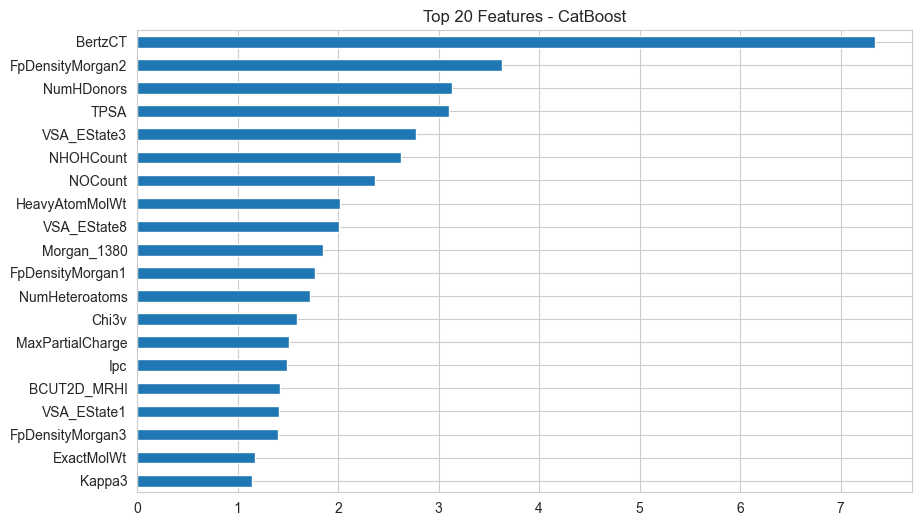

In [5]:
for name, ModelClass in model_classes.items():
    # Re-train on full dataset to get overall importance
    model = ModelClass()
    model.fit(X, y)
    
    if hasattr(model.model, 'feature_importances_'):
        importances = model.model.feature_importances_
        feat_imp_df = pd.Series(importances, index=X.columns).sort_values(ascending=False)
        
        plt.figure(figsize=(10, 6))
        feat_imp_df.head(20).plot(kind='barh')
        plt.title(f'Top 20 Features - {name}')
        plt.gca().invert_yaxis()
        plt.show()

## 5. Submission
Create submissions for individual models and a simple blended average.

In [6]:
# Individual Submissions
for name, preds in test_preds_dict.items():
    submission = pd.DataFrame({'id': test_df['id'], 'Tm': preds})
    submission.to_csv(f'../submissions/submission_{name.lower()}.csv', index=False)
    print(f"Saved {name} submission.")

# Simple Blend (Average of 3)
blend_preds = (test_preds_dict['XGBoost'] + test_preds_dict['LightGBM'] + test_preds_dict['CatBoost']) / 3
submission_blend = pd.DataFrame({'id': test_df['id'], 'Tm': blend_preds})
submission_blend.to_csv('../submissions/submission_tree_blend.csv', index=False)
print("Saved Blended submission.")

Saved XGBoost submission.
Saved LightGBM submission.
Saved CatBoost submission.
Saved Blended submission.
